In [9]:
from collections import Counter

import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression


# Constants
DATA_FILENAME = "../data/accepted_2007_to_2018Q4_cleared.csv"
FEATURE_SELECTION_DATA_FILENAME = '../data/accepted_2007_to_2018Q4_selected_features.csv'

IS_SAVE_TO_FILE = False  # True
IS_PLOT_HEAT_MAP = False  # True

TARGET_FEATURE = 'loan_status'

In [16]:
data = pd.read_csv(DATA_FILENAME)
data.shape

(1416437, 13)

In [17]:
data.head(5)

,loan_amnt,term,int_rate,sub_grade,emp_length,annual_inc,loan_status,dti,mths_since_recent_inq,revol_util,bc_open_to_buy,bc_util,num_op_rev_tl
0,3600.0,1.0,13.99,13,10.0,55000.0,0.0,5.91,4.0,29.7,1506.0,37.2,4.0
1,20000.0,2.0,10.78,8,10.0,63000.0,0.0,10.78,10.0,56.2,2737.0,55.9,4.0
2,10400.0,2.0,22.45,25,3.0,104433.0,0.0,25.37,1.0,64.5,4567.0,77.5,7.0
3,20000.0,1.0,8.49,5,10.0,85000.0,0.0,17.61,8.0,5.7,13674.0,5.7,3.0
4,10000.0,1.0,6.49,1,6.0,85000.0,0.0,13.07,1.0,34.5,8182.0,50.1,13.0


In [23]:
data['loan_status'].value_counts()

0.0    981627
1.0    185945
Name: loan_status, dtype: int64

In [25]:
185945 / (981627 + 185945) * 100 
# only 16 % not fully paid or current => unbalanced classification problem

15.92578444841089

In [33]:
# Categorical analyse
# How loan status depends on borrow's employment length

employment_length = data.groupby(['emp_length','loan_status'])['loan_status'].count()

# Find in % the number of paid/not paid per emp;oyment length
employment_length = employment_length.groupby('emp_length').apply(lambda x: x * 100 / np.sum(x))
employment_length = employment_length.unstack()

employment_length

loan_status,0.0,1.0
emp_length,,
0.0,83.984642,16.015358
1.0,83.587855,16.412145
2.0,84.074952,15.925048
3.0,83.767720,16.232280
4.0,84.016909,15.983091
5.0,83.943447,16.056553
6.0,83.981044,16.018956
7.0,83.385072,16.614928
8.0,82.866337,17.133663


<AxesSubplot:xlabel='emp_length'>

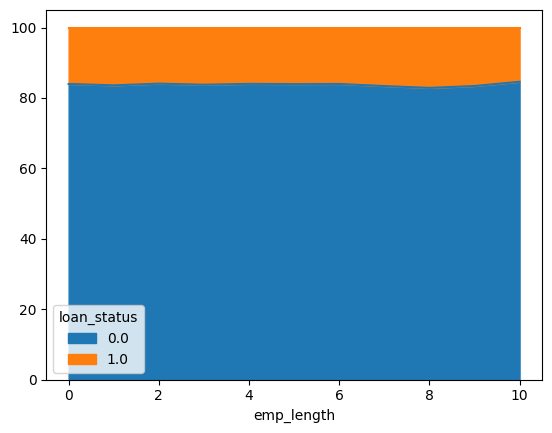

In [36]:
employment_length.plot.area()

# We can see that the loan status does not depend on employment length

(array([114264.,  95277., 133453., 119521.,  90378.,  93054.,  69069.,
         62980.,  63132., 575309.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

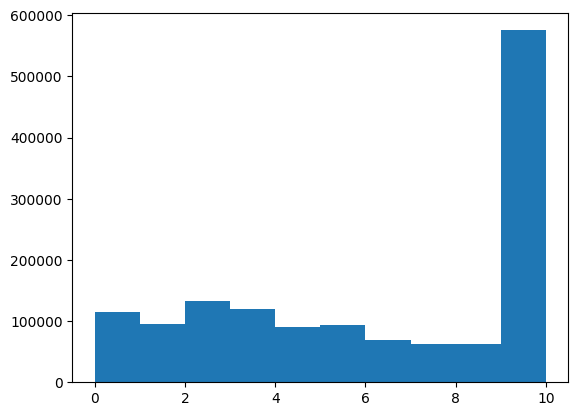

In [37]:
plt.hist(data.emp_length)

In [38]:
# How loan status depends on borrow's term
# Term could be 36 months -> 1, or 60 months -> 2

term = data.groupby(['term','loan_status'])['loan_status'].count()
term = term.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
term = term.unstack()
term

loan_status,0.0,1.0
term,,
1.0,86.963494,13.036506
2.0,77.659272,22.340728


<AxesSubplot:xlabel='term'>

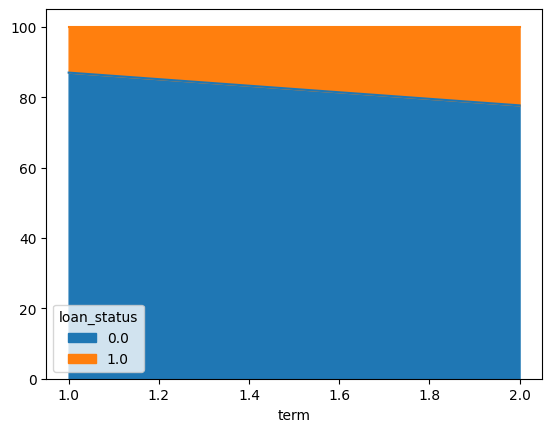

In [39]:
term.plot.area()
# We can see that borrowers with shorter term length (36 months) are more likely to paid loan

<AxesSubplot:xlabel='sub_grade'>

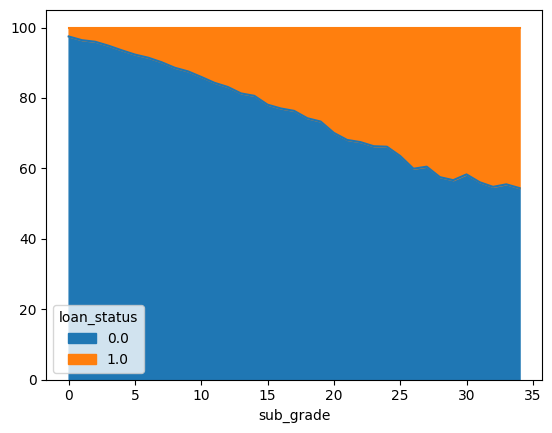

In [44]:
# How does loan status depend on subgrate?
sub_grade = data.groupby(['sub_grade','loan_status'])['loan_status'].count()

# Find in % the number of paid/not paid per employment length
sub_grade = sub_grade.groupby('sub_grade').apply(lambda x: x * 100 / np.sum(x))
sub_grade = sub_grade.unstack()

sub_grade.plot.area()

# We see visible decrease in % of paid loans with the increase of sub grate 

<AxesSubplot:>

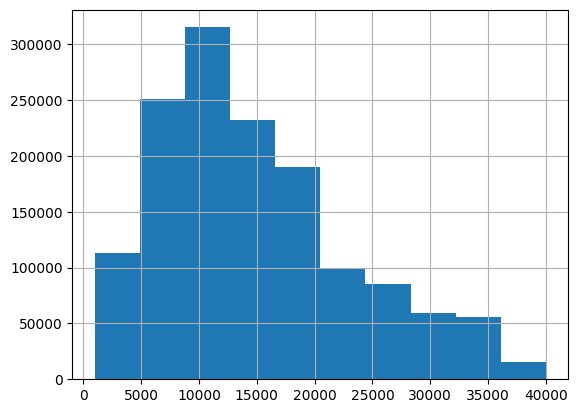

In [49]:
# Numerical features analyse
data['loan_amnt'].hist()

In [58]:
data.groupby('loan_status')['loan_amnt'].mean()
# Mean loan amounts for paid and not-paid groups are close,
# but not-paid group has higher loan amount

loan_status
0.0    14651.965130
1.0    16247.960284
Name: loan_amnt, dtype: float64

In [68]:
loan_amnt = data.groupby('loan_status')['loan_amnt']

loan_amnt.get_group(0.0).describe() # info for paid group

count    981627.000000
mean      14651.965130
std        8435.512454
min        1000.000000
25%        8000.000000
50%       13000.000000
75%       20000.000000
max       40000.000000
Name: loan_amnt, dtype: float64

In [69]:
loan_amnt.get_group(1.0).describe() # info for non-paid group

count    185945.000000
mean      16247.960284
std        8397.346334
min        1000.000000
25%       10000.000000
50%       15000.000000
75%       21000.000000
max       40000.000000
Name: loan_amnt, dtype: float64

<AxesSubplot:>

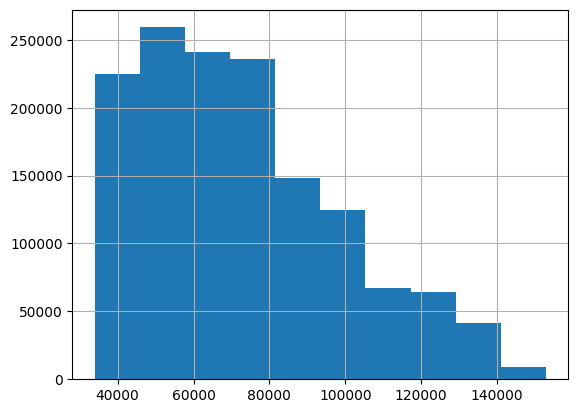

In [70]:
# Annual income
data['annual_inc'].hist()

In [72]:
annual_inc = data.groupby('loan_status')['annual_inc']

annual_inc.get_group(0.0).describe() # info for paid group

count    981627.000000
mean      72854.462013
std       25988.763896
min       34008.000000
25%       52000.000000
50%       68000.000000
75%       90000.000000
max      149999.000000
Name: annual_inc, dtype: float64

In [73]:
annual_inc.get_group(1.0).describe() # info for non-paid group

count    185945.000000
mean      69671.895094
std       24880.610986
min       34008.000000
25%       50000.000000
50%       65000.000000
75%       85000.000000
max      149999.000000
Name: annual_inc, dtype: float64

In [89]:
# Split income amount into categories 
income_options = np.arange(20000, 180000, step=20000) 
labels = ['(20-40k]', '(40-60k]', '(60-80k]', '(80-100k]',
          '(100-120k]','(120-140k]', '(140-160k]']

data['incom_options'] = pd.cut(data['annual_inc'], bins=income_options, labels=labels)
loan_income_options = data.groupby(['incom_options','loan_status'])['loan_status'].count()

loan_income_options = loan_income_options.groupby('incom_options').apply(lambda x: x * 100 / np.sum(x))
loan_income_options = loan_income_options.unstack()
loan_income_options

loan_status,0.0,1.0
incom_options,,
(20-40k],81.684184,18.315816
(40-60k],82.691578,17.308422
(60-80k],84.066808,15.933192
(80-100k],85.381376,14.618624
(100-120k],86.588269,13.411731
(120-140k],87.328779,12.671221
(140-160k],89.480048,10.519952


<AxesSubplot:xlabel='incom_options'>

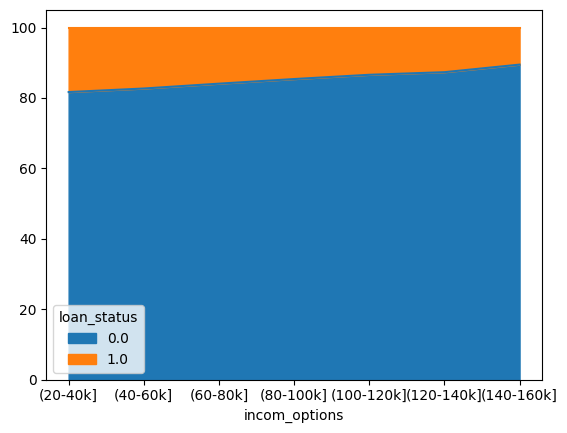

In [90]:
loan_income_options.plot.area()
# Result: higher annual income -> more likely to pay the loan

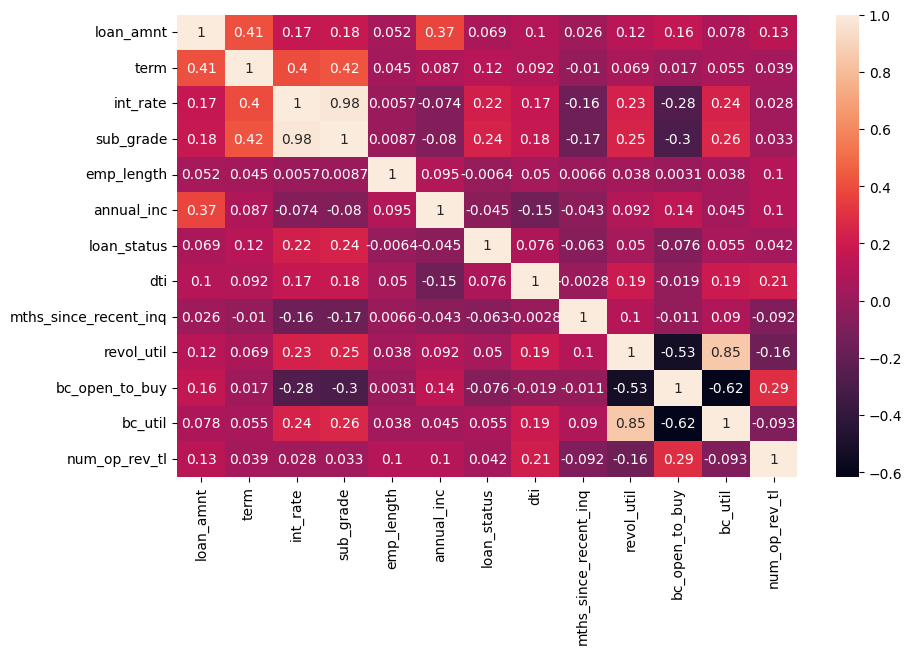

In [91]:
# Data correlation
data_corr = data.corr()
plt.figure(figsize=(10, 6))
ax = sns.heatmap(data_corr, annot=True)
plt.show()